In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import calendar
from pandas.tseries import offsets
import os
from datetime import date
import holidays

%matplotlib inline  

blues = [x for x in reversed(sns.color_palette("Blues_d", 11))]

In [2]:
path = r'/Users/macintosh/Documents/OneDrive - Cardiff University/04 - Projects/02 - Warwick/04 - Data/System data/'
files=  ['Electricity demand.csv', 'Heat demand.csv']

In [3]:
def cleanAndPrepare(data, meterName):
    data["Date"]=data["Date"] + " " +data["StartTime"]
    data["Date"] = pd.to_datetime(data["Date"], format="%d/%m/%Y %H:%M")
    data.set_index("Date", drop=True, inplace=True)
    data.drop(["Meter", "Name", "SerialNumber", "Register", "StartTime", "Duration", "TotalValue", "Unit"], axis=1, inplace=True)
    data.columns = [meterName]

In [4]:
frames = []

for filename in files:
    data = pd.read_csv(path+filename)
    meterName = filename.split(".csv")[0]
    cleanAndPrepare(data, meterName)
    print(filename + " has " + '{:d}'.format(data[meterName].isnull().sum()) + " missing data")
    frames.append(data)

result = pd.concat(frames,axis=1)
result.set_index(pd.date_range(start=result.index[0], end=result.index[-1], freq='30T' ), inplace=True)
result.head()

Electricity demand.csv has 0 missing data
Heat demand.csv has 0 missing data


,Electricity demand,Heat demand
2016-01-01 00:00:00,2536,1.501
2016-01-01 00:30:00,2519,1.499
2016-01-01 01:00:00,2539,1.501
2016-01-01 01:30:00,2525,1.399
2016-01-01 02:00:00,2518,1.601


In [5]:
result["Hour"] = result.index.hour
result["DayOfWeek_name"]= [calendar.day_name[x] for x in result.index.dayofweek]
result["DayOfWeek"]= result.index.dayofweek
result["Month"] = result.index.month
result["Weekday"] = [1 if x<5 else 0 for x in result.index.dayofweek]
result["HH"] = [x%48 for x in range(0, result.shape[0], 1) ]
# result["Holiday"]= [1 if x.date() in uk_hol else 0 for x in result.index]
result["Date"] = result.index.date
result["Week"] = result.index.week

def get_season(row):
    if row['Month'] >= 3 and row['Month'] <= 5:
        return 'Spring'
    elif row['Month'] >= 6 and row['Month'] <= 8:
        return 'Summer'
    elif row['Month'] >= 9 and row['Month'] <= 11:
        return 'Autumn'
    else:
        return 'Winter'

season_dict = {"Winter":1, "Spring":2, "Summer":3, "Autumn":4}
inv_season_dict = {v: k for k, v in season_dict.items()}
result['Season'] = result.apply(get_season, axis=1)
result['Season num'] = result['Season']
result.replace({"Season num":season_dict}, inplace=True)
result.head()

,Electricity demand,Heat demand,Hour,DayOfWeek_name,DayOfWeek,Month,Weekday,HH,Date,Week,Season,Season num
2016-01-01 00:00:00,2536,1.501,0,Friday,4,1,1,0,2016-01-01,53,Winter,1
2016-01-01 00:30:00,2519,1.499,0,Friday,4,1,1,1,2016-01-01,53,Winter,1
2016-01-01 01:00:00,2539,1.501,1,Friday,4,1,1,2,2016-01-01,53,Winter,1
2016-01-01 01:30:00,2525,1.399,1,Friday,4,1,1,3,2016-01-01,53,Winter,1
2016-01-01 02:00:00,2518,1.601,2,Friday,4,1,1,4,2016-01-01,53,Winter,1


/Users/macintosh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


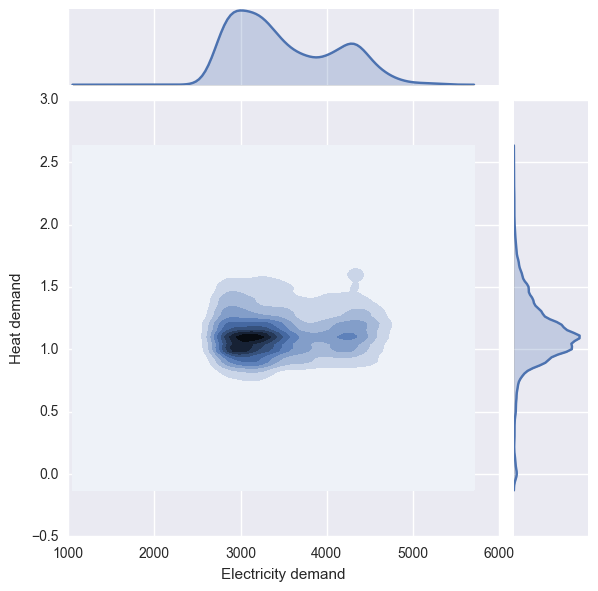

In [6]:
season="Summer"
g = sns.jointplot(x="Electricity demand", y="Heat demand", data=result.loc[result["Season"]==season, :], kind="kde", stat_func=None)
plt.savefig(path+season+"density-distribution.png")

In [13]:
season= "Summer"
bins_size = 10
H, xedges, yedges= np.histogram2d(x=result.loc[result["Season"]==season, "Electricity demand"], y=result.loc[result["Season"]==season, "Heat demand"], bins=bins_size)
H= H.T
length_data = result.loc[result["Season"]==season, :].shape[0]
histogram=pd.DataFrame(data=H/length_data, columns= xedges[1:], index=yedges[1:])
histogram.to_csv(path+"Histogram-"+season+".csv")

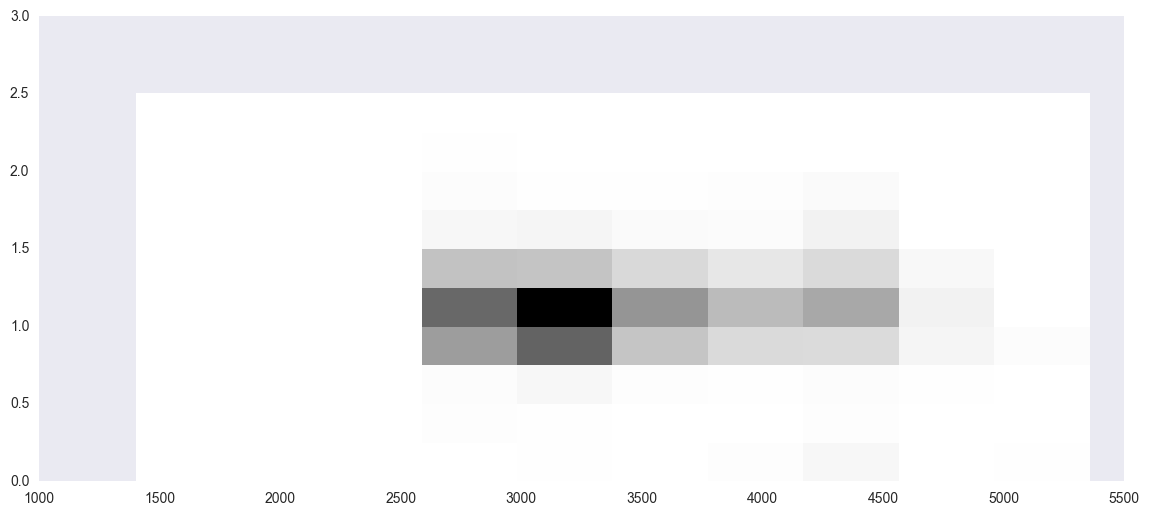

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)

In [9]:
length_data = result.loc[result["Season"]=="Winter", :].shape[0]

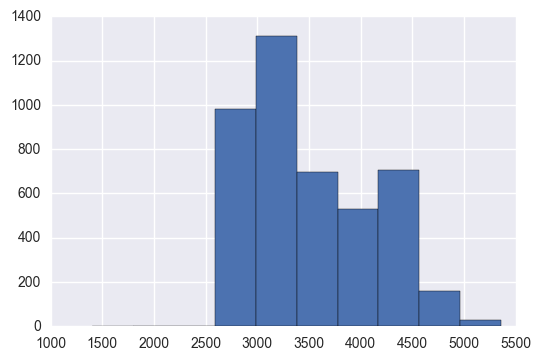

In [10]:
result.loc[result["Season"]==season, "Electricity demand"].hist()

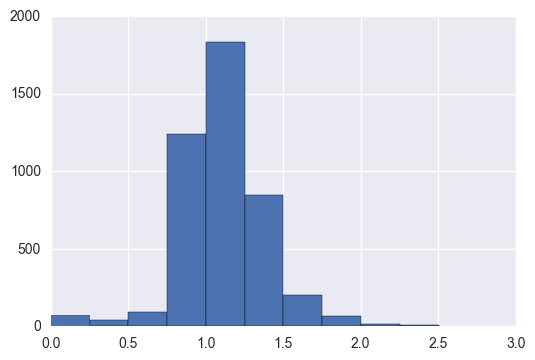

In [11]:
result.loc[result["Season"]==season, "Heat demand"].hist()

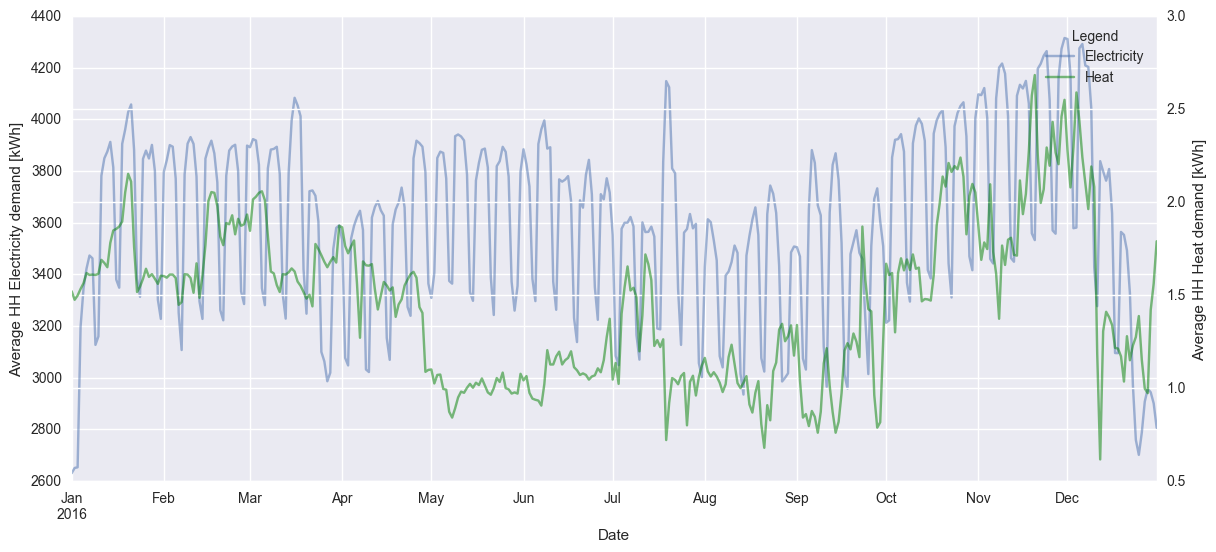

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))
ax2 = ax.twinx()
result.loc[:, "Electricity demand"].resample('d').mean().plot(ax=ax, alpha=0.5, label="Electricity")
result.loc[:, "Heat demand"].resample('d').mean().plot(ax=ax2, color='green', alpha=0.5, label="Heat")
ax.set_xlabel("Date")
ax.set_ylabel("Average HH Electricity demand [kWh]")
ax2.set_ylabel("Average HH Heat demand [kWh]")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines= lines+lines2
labels=labels+labels2
ax.legend(lines, labels, title="Legend")
plt.savefig(path+"annual-demand.png")